<font face="Times New Roman">
<div dir=ltr align=center>
<font color=3C99D size=8>
    Random Forest and XGboost

### Breasr Cancer
In this practical assignment, you are going to train a Random Forest and XGBoost model on <code>breast_cancer.csv</code> dataset to predict the survive rate of the patients.

In [1]:
# !pip install xgboost

In [4]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from xgboost import plot_tree
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, RepeatedKFold, StratifiedKFold
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, ConfusionMatrixDisplay, roc_auc_score, roc_curve

#### Loading the Data

In [5]:
df = pd.read_csv("./breast_cancer.csv")

In [6]:
df.isna().sum().sum()

461

### Data Exploration

In [7]:
df.head(5)

,Unnamed: 0,age_at_diagnosis,type_of_breast_surgery,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,er_status,...,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,oncotree_code,pr_status,radio_therapy,3-gene_classifier_subtype,tumor_size,tumor_stage,overall_survival
0,0,75.65,MASTECTOMY,Breast Invasive Ductal Carcinoma,NaN,0,claudin-low,1.0,Positve,Positive,...,10.0,5.697687,6.044,IDC,Negative,1,ER-/HER2-,22.0,2.0,1
1,1,43.19,BREAST CONSERVING,Breast Invasive Ductal Carcinoma,High,0,LumA,1.0,Positve,Positive,...,0.0,2.000000,4.020,IDC,Positive,1,ER+/HER2- High Prolif,10.0,1.0,1
2,2,48.87,MASTECTOMY,Breast Invasive Ductal Carcinoma,High,1,LumB,1.0,Positve,Positive,...,1.0,2.000000,4.030,IDC,Positive,0,NaN,15.0,2.0,0
3,3,47.68,MASTECTOMY,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,1.0,Positve,Positive,...,3.0,1.000000,4.050,MDLC,Positive,1,NaN,25.0,2.0,1
4,4,76.97,MASTECTOMY,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,1.0,Positve,Positive,...,8.0,2.000000,6.080,MDLC,Positive,1,ER+/HER2- High Prolif,40.0,2.0,0


In [8]:
df.describe()

,Unnamed: 0,age_at_diagnosis,chemotherapy,cohort,neoplasm_histologic_grade,hormone_therapy,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,radio_therapy,tumor_size,tumor_stage,overall_survival
count,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000
mean,951.500000,61.087054,0.207983,2.643908,2.415939,0.616597,2.002101,5.697687,4.033019,0.597164,26.238726,1.750535,0.420693
std,549.781775,12.978711,0.405971,1.228615,0.638185,0.486343,4.079993,4.010503,1.144492,0.490597,15.081097,0.539889,0.493800
min,0.000000,21.930000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000
25%,475.750000,51.375000,0.000000,1.000000,2.000000,0.000000,0.000000,3.000000,3.046000,0.000000,17.000000,1.000000,0.000000
50%,951.500000,61.770000,0.000000,3.000000,2.415939,1.000000,0.000000,5.000000,4.042000,1.000000,23.000000,1.750535,0.000000
75%,1427.250000,70.592500,0.000000,3.000000,3.000000,1.000000,2.000000,7.000000,5.040250,1.000000,30.000000,2.000000,1.000000
max,1903.000000,96.290000,1.000000,5.000000,3.000000,1.000000,45.000000,80.000000,6.360000,1.000000,182.000000,4.000000,1.000000


### Data Preparation
#### Creatinging two custom transformers to put on our pipeline:
* To split the data into categorical and numerical features and
* To preprocess the categorical features. 
* Create the X feature matrix and the y target vector.
* split the data.

In [9]:
class FeatureSelector(BaseEstimator, TransformerMixin):
  def __init__(self, f_type=None):
    self.f_type = f_type

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    columns = []
    if self.f_type == 'categorical':
      for (i, t) in enumerate(X.dtypes):
        if t == 'object':
          columns.append(i)
    else:
      for (i, t) in enumerate(X.dtypes):
        if t != 'object':
          columns.append(i)
    return X.iloc[:, columns]

class CategoricalImputer(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    self.y = y
    return self

  def transform(self, X):
    X.loc[:, 'overall_survival'] = self.y
    f = lambda x: x.mode().iloc[0]
    X = X.fillna(X.groupby("overall_survival").transform(f))
    return X.iloc[:, X.columns != "overall_survival"]

In [10]:
df = df.drop(columns=['Unnamed: 0'])

categorical_transformer = Pipeline(steps=[
    ('feature selector', FeatureSelector(f_type='categorical')),
    ('imputer', CategoricalImputer()),
    ('encoder', OneHotEncoder())
])
numerical_transformer = Pipeline(steps=[
    ('feature selector', FeatureSelector(f_type='numerical')),
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler())
])

preprocess = ColumnTransformer(
   transformers=[
    ('categorical', categorical_transformer, [_ for _ in range(len(df.columns)-1)]),
    ('numerical', numerical_transformer, [_ for _ in range(len(df.columns)-1)])
])

y = 'overall_survival'
x = df.loc[:, df.columns != y].columns
data = preprocess.fit_transform(df[x], df[y])

x_train, x_test, y_train, y_test = train_test_split(data, df[y], test_size = 0.2, stratify=df[y], random_state=1)

<ipython-input-9-e15589adbe27>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:, 'overall_survival'] = self.y


# Implementing two different models

## Random Forest

### train the model

In [ ]:
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)
prediction = rfc.predict(x_test)

### Model assessment

In [ ]:
confusion = confusion_matrix(y_test, prediction)
accuracy = accuracy_score(y_test, prediction)
f1 = f1_score(y_test, prediction)

print('Confusion:\n', confusion)
print('Accuracy:', accuracy)
print('F1 Score:', f1)

### Hyperparameter tuning :
Randomized Search Cross Validation and Grid Search Cross Validation

In [ ]:
model = RandomForestClassifier()
params = {
    'n_estimators': [50, 100, 150, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 5],
    'min_samples_split': [2, 4, 6],
    'max_features': ['sqrt', 5, 'log2'],
    'bootstrap': [True, False]
}

cv = RepeatedKFold(random_state=0)

search = GridSearchCV(model, params, scoring='f1', n_jobs=-1, cv=cv)

result = search.fit(x_train, y_train)

print('Best Score:', result.best_score_)
print('Best Hyperparameters:', result.best_params_)

In [ ]:
model = RandomForestClassifier()
params = {
    'n_estimators': [150, 200, 250, 300],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 3, 5],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 3, 5, 6],
    'bootstrap': [True, False]
}

cv = RepeatedKFold(random_state=0)

search = RandomizedSearchCV(model, params, n_iter=500, scoring='f1', n_jobs=-1, cv=cv, random_state=0)

result = search.fit(x_train, y_train)

print('Best Score:', result.best_score_)
print('Best Hyperparameters:', result.best_params_)

#### Based on Grid and Random search, Training model again

In [ ]:
rfc = RandomForestClassifier(n_estimators=200, min_samples_split=4, criterion='entropy', bootstrap=True)
rfc.fit(x_train, y_train)
prediction = rfc.predict(x_test)

confusion = confusion_matrix(y_test, prediction)
accuracy = accuracy_score(y_test, prediction)
f1 = f1_score(y_test, prediction)

print('Confusion:\n', confusion)
print('Accuracy:', accuracy)
print('F1 Score:', f1)

### Find important features with Random Forest model 
visualizing feature scores of the features

In [ ]:
importance = pd.DataFrame({
    'feature': [_ for _ in range(x_train.shape[1])],
    'importance': np.round(rfc.feature_importances_, 4)
})
importance = importance.sort_values('importance', ascending=False).set_index('feature')

importance.plot(kind='bar', figsize=(20, 10))
plt.show()

### Improve Model

Here we're going to only use 6 of the most important features that we got from previous classification "importance". As we can see this 6 features helped model not only from bias, but we are getting higher accuracy and F1 score.

In [ ]:
features = list(importance.index[:6])

rfc = RandomForestClassifier(n_estimators=200, min_samples_split=4, criterion='entropy', bootstrap=True)
rfc.fit(x_train[:, features], y_train)
prediction = rfc.predict(x_test[:, features])

confusion = confusion_matrix(y_test, prediction)
accuracy = accuracy_score(y_test, prediction)
f1 = f1_score(y_test, prediction)

print('Confusion:\n', confusion)
print('Accuracy:', accuracy)
print('F1 Score:', f1)

## XGBoost
### Train the model

In [11]:
model = XGBClassifier()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

### Model assessment

In [17]:
confusion = confusion_matrix(y_test, y_pred, labels=model.classes_)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print('Confusion:\n', confusion)
print('Accuracy:', accuracy)
print('F1 Score:', f1)
print('ROC-AUC:', roc_auc)

Confusion:
 [[167  54]
 [ 59 101]]
Accuracy: 0.7034120734908137
F1 Score: 0.6412698412698413
ROC-AUC: 0.6934530542986425


### Plot the results

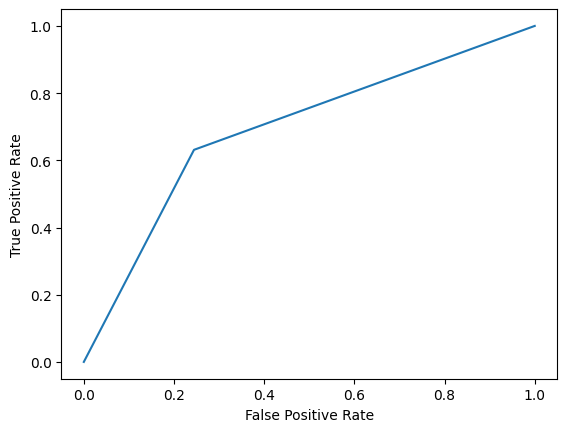

In [15]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

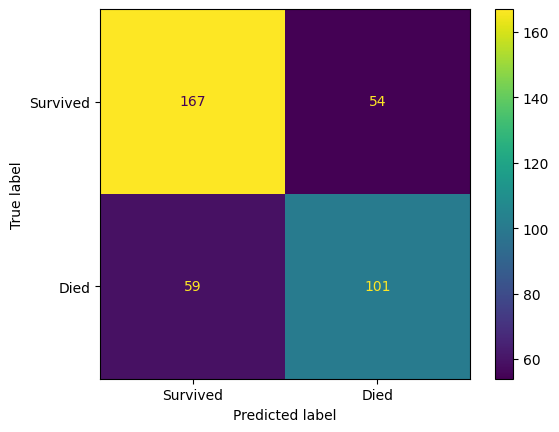

In [13]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=['Survived', 'Died'])
disp.plot()
plt.show()

### Hyperparameter Tuning: Grid Search and Cross Validation

In [ ]:
model = XGBClassifier()
params = {
    'n_estimators': [150, 200, 250, 300],
    'learning_rate': [0.1, 0.01, 0.05],
    'max_depth': [3, 6],
    'min_child_weight': [1, 3, 6]
}

cv = StratifiedKFold(shuffle=True, random_state=0)

search = RandomizedSearchCV(model, params, scoring='roc_auc', n_jobs=-1, cv=cv, random_state=0)

result = search.fit(x_train, y_train)

print('Best Score:', result.best_score_)
print('Best Hyperparameters:', result.best_params_)

### Assessing model performance using the best model from grid search

In [ ]:
model = XGBClassifier(n_estimators=150, max_depth=3, learning_rate=0.05)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('Accuracy:', accuracy)
print('F1 Score:', f1)

### Create the feature importances plot, plot a decision tree from the booster.

In [ ]:
importance = pd.DataFrame({
    'feature': [_ for _ in range(x_train.shape[1])],
    'importance': np.round(model.feature_importances_, 4)
})
importance = importance.sort_values('importance', ascending=False).set_index('feature')

importance.plot(kind='bar', figsize=(12, 8))
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(20, 15))
plot_tree(model, ax=ax, rankdir='LR')
plt.show()

### Improve Model

#### For improvement we're using features that have `importance > 0`. This will improve time complexity of model (29 feature were redundant), but no improvements for accuracy of the model. For Accuracy improvement we can use GridSearchCV to check all parameters instead of choosing random permutations.

In [ ]:
features = list(importance.index[:45])

model = XGBClassifier(n_estimators=150, max_depth=3, learning_rate=0.05)
model.fit(x_train[:, features], y_train)
prediction = model.predict(x_test[:, features])

accuracy = accuracy_score(y_test, prediction)
f1 = f1_score(y_test, prediction)

print('Accuracy:', accuracy)
print('F1 Score:', f1)

## Comparison between XGBoost and Random Forest Classifier

Accuracy-wise Random Forest had better accuray and F1 score.
Time-wise XGBoost was faster to compute.
Parameter tuning is easier for Random Forest. When we preprocess the data and we have a clean one it's better to use Random Forest. 
In Random Forest we could use only six features (that were the most important) and get better results. However, for XGBoost we must have used all the feature with `importance > 0` to get the maximum accuracy.